# Import Required Libraries

In [12]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras_preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
import pickle
import os
# os.getcwd()
home = os.getcwd()
# % matplotlib inline
pd.set_option('display.max_colwidth', 200)

### Define preprocess functions

In [13]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

In [14]:
# split a text into sentences from the text file
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [15]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [16]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [17]:
# read text file
os.chdir(home)
if not os.path.exists('Translator'):
    os.mkdir('Translator')
os.chdir('Translator')

In [18]:
data_name = "nld.txt"
data = read_text(data_name)
# data
deu_eng = to_lines(data)
deu_eng = array(deu_eng)
len(deu_eng)

FileNotFoundError: [Errno 2] No such file or directory: 'nld.txt'

In [8]:
# trim and preview file
deu_eng = deu_eng[:50000,:]
deu_eng[1:5]

array([['Go.', 'Vooruit.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #7915821 (Elsofie)'],
       ['Hi.', 'Hoi.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #537889 (Dorenda)'],
       ['Hi.', 'Hé!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #6117419 (Raizin)'],
       ['Hi.', 'Hai!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #6117420 (Raizin)']],
      dtype='<U286')

In [9]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

In [10]:
# convert to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    
    deu_eng[i,1] = deu_eng[i,1].lower()

In [11]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
    eng_l.append(len(i.split()))

# populate the lists with sentence lengths
for i in deu_eng[:,1]:
    deu_l.append(len(i.split()))

In [12]:
# initialize df for bar plotting
length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

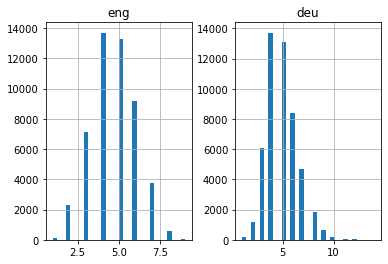

In [13]:
# plot bar to identify a suitable sequence length
length_df.hist(bins = 30)
plt.show()

In [14]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 7487


In [15]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

# chos sequence length is 8
deu_length = 8
# identify unique words
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 10320


In [16]:
# make a file to pickle tokenizers for prediction
if not os.path.exists('Tokenizer'):
    os.mkdir('Tokenizer')
os.chdir('Tokenizer')

# initialize a name for saving
name = data_name.split(".")[0]

# pickle file with the name and pickle tag
filename = name+'_eng_tokenizer.pickle'
with open(filename, 'wb') as handle:
    pickle.dump(eng_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
# pickle file with the name and pickle tag
filename = name+'_deu_tokenizer.pickle'
with open(filename, 'wb') as handle:
    pickle.dump(deu_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Model Preprocessing

In [17]:
# split test and training data
from sklearn.model_selection import train_test_split
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

In [18]:
# prepare training sequences
trainX = encode_sequences(eng_tokenizer, eng_length, train[:, 0])
trainY = encode_sequences(deu_tokenizer, deu_length, train[:, 1])

In [19]:
# prepare validation sequences
testX = encode_sequences(eng_tokenizer, eng_length, test[:, 0])
testY = encode_sequences(deu_tokenizer, deu_length, test[:, 1])

In [20]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [21]:
# Initialize model paramaters
model = build_model(eng_vocab_size, deu_vocab_size, eng_length,deu_length, 512)
rms = optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [22]:
os.chdir(home)
os.chdir('Translator')

if not os.path.exists('Models'):
    os.mkdir('Models')
os.chdir('Models')

In [ ]:
import datetime
date=datetime.datetime.now()

In [36]:
# Train Model
filename = str(date) + 'present_model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=50, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Epoch 1/50
63/63 [==============================] - ETA: 0s - loss: 3.7030
Epoch 1: val_loss improved from inf to 3.68946, saving model to present_model.h5
63/63 [==============================] - 122s 2s/step - loss: 3.7030 - val_loss: 3.6895
Epoch 2/50
63/63 [==============================] - ETA: 0s - loss: 3.5173
Epoch 2: val_loss improved from 3.68946 to 3.60880, saving model to present_model.h5
63/63 [==============================] - 126s 2s/step - loss: 3.5173 - val_loss: 3.6088
Epoch 3/50
63/63 [==============================] - ETA: 0s - loss: 3.3789
Epoch 3: val_loss improved from 3.60880 to 3.47148, saving model to present_model.h5
63/63 [==============================] - 88s 1s/step - loss: 3.3789 - val_loss: 3.4715
Epoch 4/50
63/63 [==============================] - ETA: 0s - loss: 3.2373
Epoch 4: val_loss improved from 3.47148 to 3.33286, saving model to present_model.h5
63/63 [==============================] - 85s 1s/step - loss: 3.2373 - val_loss: 3.3329
Epoch 5/50
63/

KeyboardInterrupt: 

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

NameError: name 'history' is not defined

In [34]:
# filename = str(date) + '_ENG_TO_DEU.h5'
# model.save(filename, save_format="h5")

OSError: Unable to create file (unable to open file: name = '2022-06-17 15:17:06.977984_ENG_TO_DEU', errno = 22, error message = 'Invalid argument', flags = 13, o_flags = 302)

# Make Predictions

In [304]:
# os.getcwd()

'C:\\Users\\Acer\\123 NLP'

In [53]:
# testX.shape[0]
# testX.shape[1]

In [54]:
# testX[0]

'present_model.h5'

In [40]:
import numpy as np
os.chdir(home)
os.chdir('Translator\\Models')
model = load_model(os.listdir()[0])
# Predict the first item in tmp_x
prediction = model.predict(testX)

313/313 [==============================] - 44s 126ms/step


In [41]:
# Define a funcction for converting logits into text
def logits_to_text(logits, tokenizer):
    
    # Get index to words
    index2word = {id: word for word, id in tokenizer.word_index.items()}
    
    # Add '<PAD>' at start of index2word
    index2word[0] = ''
    
    # Get the text
    text = " ".join([index2word[prediction] for prediction in np.argmax(logits, 1)])
    
    return text

In [42]:
# Convert the logits into text
predicted_text = []
for i in prediction:
    predicted_text.append(logits_to_text(logits = i, tokenizer = deu_tokenizer))
# print(predicted_text)

In [43]:
pred_df = pd.DataFrame({'actual' : test[:,1], 'predicted' : predicted_text})

In [44]:
pd.set_option('display.max_colwidth', 200)

In [45]:
pred_df.head(10)

,actual,predicted
0,ik kon mijn eigen ogen niet geloven,ik kon mijn ogen niet geloven
1,lach naar het vogeltje,zeg kaas
2,hij haat spinnen,hij haat spinnen
3,meende tom het serieus,was tom tom
4,waar bent u naar op zoek meneer,wat zoek jullie naar
5,tom en maria liften,tom en mary zijn van het
6,die kamer wordt als keuken gebruikt,deze kamer is een een mijn
7,hij is bang dat hij zal sterven,hij is of hij hij moet
8,hij wilde slagen,hij wilde later
9,ik woon nog steeds in australië,ik woon nog steeds in


In [46]:
pred_df.tail(15)

,actual,predicted
9985,die vind ik leuker,ik vind dat dat goed
9986,ik heb de deur van het slot gehaald,ik deed de deur dicht
9987,misschien is tom niet slaperig,tom kan zijn dat niet niet slaperig is
9988,ik kan voor mezelf opkomen,ik spreek op op muziek
9989,tom kwam heel laat aan,tom is hier laat
9990,tom heeft de hele zak opgegeten,tom heeft de de van
9991,we moeten ons registreren,we hebben elkaar
9992,was het goed,was het goed
9993,je was met tom aan het flirten,je bent met op tom
9994,is dat tom zijn vrouw,is dat tom hond hond


In [47]:
pred_df.tail(15)

,actual,predicted
9985,die vind ik leuker,ik vind dat dat goed
9986,ik heb de deur van het slot gehaald,ik deed de deur dicht
9987,misschien is tom niet slaperig,tom kan zijn dat niet niet slaperig is
9988,ik kan voor mezelf opkomen,ik spreek op op muziek
9989,tom kwam heel laat aan,tom is hier laat
9990,tom heeft de hele zak opgegeten,tom heeft de de van
9991,we moeten ons registreren,we hebben elkaar
9992,was het goed,was het goed
9993,je was met tom aan het flirten,je bent met op tom
9994,is dat tom zijn vrouw,is dat tom hond hond


In [48]:
pred_df.sample(15)

,actual,predicted
7330,ik ben er zeker van dat we veel gemeen hebben,ik weet niet veel veel veel
3335,ze verkoopt groenten,ze verkoopt groentes
5312,hij kan ieder moment terug zijn,hij zou hier zijn zijn zijn
4083,laten we naar het strand gaan,laten we naar het strand gaan
5750,de hitte is overweldigend,de maan is aan tikken
7182,we moeten een plan hebben,we moeten een plan
8651,hij weet wie we zijn,hij weet wie wie zijn
8973,laten we niet gaan,laten we niet niet
5986,hoeveel kostte dat bier,hoeveel kost deze stropdas
335,ik heb nooit van je gehouden,ik heb nooit van je gehouden


In [49]:
test[8174]

array(['its time to pack up', 'het is tijd om in te pakken',
       'CC-BY 2.0 (France) Attribution: tatoeba.org #7913357 (CK) & #7928755 (MarijnKp)'],
      dtype='<U286')

In [50]:
query = 'its time to pack up'

In [51]:
querye = query[0].translate(str.maketrans('', '', string.punctuation))
encoded_query = encode_sequences(eng_tokenizer, eng_length, querye)

In [250]:
# Convert the logits into text
predicted_text = []
for i in prob:
    predicted_text.append(logits_to_text(logits = i, tokenizer = deu_tokenizer))

In [253]:
print(predicted_text[0])

ik dacht hoopte hoopte ongemakkelijk beloofd beloofd verzetten


In [254]:
pred_df = pd.DataFrame({'actual' : query, 'predicted' : predicted_text})

In [255]:
pred_df

,actual,predicted
0,its time to pack up,ik dacht hoopte hoopte ongemakkelijk beloofd beloofd verzetten
1,its time to pack up,
2,its time to pack up,
3,its time to pack up,
4,its time to pack up,
5,its time to pack up,ik dacht hoopte hoopte ongemakkelijk beloofd beloofd verzetten
6,its time to pack up,
7,its time to pack up,
8,its time to pack up,
9,its time to pack up,


couldnt work it out but it seemed to do fine with a data set so with the dataset of notes theat ive made il throw through the model